# Creating a Demonstration of Synthetic Clouds

This notebook demonstrates how to generate synthetic cloud data for testing and visualization purposes. It includes steps to create cloud-like structures using Gaussian filters, save the data in NetCDF format, and visualize the results. This can be useful for testing algorithms or creating example datasets for analysis.

In [ ]:
import numpy as np
import netCDF4 as nc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

### 1.  Prepare Parameters

In [8]:
# Parameters
domain_size = (150, 150)
timesteps = 20

# Cloud parameters
# Define the parameters for each cloud in a dictionary
clouds = [
    {
        'name': 'Cloud 1',
        'initial_center_x': domain_size[0] // 4,
        'initial_center_y': domain_size[1] // 2,
        'dx': 1,  # Initial movement direction in x (1 for right, -1 for left)
        'dy': 1,  # Initial movement direction in y (1 for up, -1 for down)
        'move_x': domain_size[0] // (timesteps * 1.5),
        'move_y': domain_size[1] // (timesteps * 2),
        'sigma_tb_min': 0.15, # Minimum sigma for Tb Gaussian (initial cloud size)
        'sigma_tb_max': 6,       # Maximum sigma for Tb Gaussian (maximum cloud size)
        'amplitude_tb_min': 0.05,  # Initial amplitude of Tb Gaussian (initial intensity)
        'amplitude_tb_max': 1.0,   # Maximum amplitude of Tb Gaussian (peak intensity)
        'sigma_pr_min': 0.05,    # Minimum sigma for pr Gaussian (initial precipitation area size)
        'sigma_pr_max': 4,       # Maximum sigma for pr Gaussian (maximum precipitation area size)
        'amplitude_pr_min': 0.5,   # Initial amplitude of pr Gaussian (initial precipitation intensity)
        'amplitude_pr_max': 1.0,   # Maximum amplitude of pr Gaussian (peak precipitation intensity)
    },
    {
        'name': 'Cloud 2',
        'initial_center_x': domain_size[0] * 3 // 4,  # Adjusted for better separation
        'initial_center_y': domain_size[1] // 2,
        'dx': -1,  # Moves left
        'dy': -1,  # Moves down
        'move_x': domain_size[0] // (timesteps * 1.5),
        'move_y': domain_size[1] // (timesteps * 2),
        'sigma_tb_min': 0.15,
        'sigma_tb_max':6,
        'amplitude_tb_min':0.05,
        'amplitude_tb_max':1.0,
        'sigma_pr_min':0.05,
        'sigma_pr_max':4,
        'amplitude_pr_min':0.5,
        'amplitude_pr_max':1.0,
    }
]

# Other parameters
growth_timestep = 15   # Timestep at which the cloud reaches maximum size and intensity

tb_exponent = 3        # Exponent for shaping Tb profile (controls sharpness of temperature gradient)
pr_exponent = 1        # Exponent for shaping pr profile (controls precipitation rate distribution)
pr_max = 14            # Maximum precipitation rate (mm/hr)


### 2. Create Clouds

This section generates synthetic clouds using Gaussian filters or other methods. The clouds are created as 2D arrays with varying intensity and size.

In [9]:

# Generate a meshgrid for the domain
x = np.linspace(0, domain_size[0] - 1, domain_size[0])
y = np.linspace(0, domain_size[1] - 1, domain_size[1])
x_grid, y_grid = np.meshgrid(x, y)

# Function to create a circular Gaussian distribution
def create_gaussian(center_x, center_y, sigma_x, sigma_y, amplitude):
    gauss = amplitude * np.exp(-(((x_grid - center_x) ** 2) / (2 * sigma_x ** 2) +
                                 ((y_grid - center_y) ** 2) / (2 * sigma_y ** 2)))
    return gauss

# Initialize data arrays
Tb = np.full((timesteps, domain_size[1], domain_size[0]), 300.0)
pr = np.zeros((timesteps, domain_size[1], domain_size[0]))

# Initialize clouds
for cloud in clouds:
    # Initialize current positions
    cloud['center_x'] = cloud['initial_center_x']
    cloud['center_y'] = cloud['initial_center_y']
    # Initialize lists to store center positions over time for visualization
    cloud['center_positions_x'] = []
    cloud['center_positions_y'] = []
    # Define buffer to prevent cloud from touching edges
    cloud['buffer_tb'] = cloud['sigma_tb_max'] * 3
    # Define boundaries for the center positions
    cloud['min_center_x'] = cloud['buffer_tb']
    cloud['max_center_x'] = domain_size[0] - cloud['buffer_tb']
    cloud['min_center_y'] = cloud['buffer_tb']
    cloud['max_center_y'] = domain_size[1] - cloud['buffer_tb']

# Main simulation loop
for t in range(timesteps):
    # Calculate the growth factor f(t)
    if t <= growth_timestep:
        f = t / growth_timestep
    else:
        f = (timesteps - t - 1) / (timesteps - growth_timestep - 1)

    # Initialize lists to store normalized Tb and pr for combining
    tb_normalized_list = []
    pr_normalized_list = []

    # Update each cloud
    for cloud in clouds:
        # Adjust sigma and amplitude using f(t)
        sigma_tb = cloud['sigma_tb_min'] + f * (cloud['sigma_tb_max'] - cloud['sigma_tb_min'])
        amplitude_tb = cloud['amplitude_tb_min'] + f * (cloud['amplitude_tb_max'] - cloud['amplitude_tb_min'])
        sigma_pr = cloud['sigma_pr_min'] + f * (cloud['sigma_pr_max'] - cloud['sigma_pr_min'])
        amplitude_pr = cloud['amplitude_pr_min'] + f * (cloud['amplitude_pr_max'] - cloud['amplitude_pr_min'])

        # Adjust Gaussian properties for Tb
        tb_gaussian = create_gaussian(cloud['center_x'], cloud['center_y'],
                                      sigma_x=sigma_tb, sigma_y=sigma_tb, amplitude=amplitude_tb)
        tb_gaussian_filtered = gaussian_filter(tb_gaussian, sigma=2)
        tb_normalized = tb_gaussian_filtered / np.max(tb_gaussian_filtered)
        tb_normalized_list.append(tb_normalized)

        # Adjust Gaussian properties for pr
        pr_gaussian = create_gaussian(cloud['center_x'], cloud['center_y'],
                                      sigma_x=sigma_pr, sigma_y=sigma_pr, amplitude=amplitude_pr)
        pr_gaussian_filtered = gaussian_filter(pr_gaussian, sigma=2)
        pr_normalized = pr_gaussian_filtered / np.max(pr_gaussian_filtered)
        pr_normalized_list.append(pr_normalized)

        # Store center positions for visualization
        cloud['center_positions_x'].append(cloud['center_x'])
        cloud['center_positions_y'].append(cloud['center_y'])

        # Move the Gaussian center for next timestep
        cloud['center_x'] += cloud['dx'] * cloud['move_x']
        cloud['center_y'] += cloud['dy'] * cloud['move_y']

        # Check for boundary collisions and reverse direction if necessary
        if cloud['center_x'] >= cloud['max_center_x']:
            cloud['center_x'] = cloud['max_center_x']
            cloud['dx'] *= -1
        elif cloud['center_x'] <= cloud['min_center_x']:
            cloud['center_x'] = cloud['min_center_x']
            cloud['dx'] *= -1
        if cloud['center_y'] >= cloud['max_center_y']:
            cloud['center_y'] = cloud['max_center_y']
            cloud['dy'] *= -1
        elif cloud['center_y'] <= cloud['min_center_y']:
            cloud['center_y'] = cloud['min_center_y']
            cloud['dy'] *= -1

    # Combine Tb from all clouds, taking the minimum (coldest temperature) at each point
    Tb_combined = np.full((domain_size[1], domain_size[0]), 300.0)
    for tb_normalized in tb_normalized_list:
        Tb_core = 220 + (13 * (1 - tb_normalized) ** tb_exponent)
        Tb_core = np.clip(Tb_core, 220, 240)
        Tb_combined = np.minimum(Tb_combined, np.where(tb_normalized > 0.01, Tb_core, 300.0))
    Tb[t] = Tb_combined

    # Combine pr from all clouds, summing the precipitation rates
    pr_combined = np.zeros((domain_size[1], domain_size[0]))
    for pr_normalized in pr_normalized_list:
        pr_scaled = pr_max * pr_normalized ** pr_exponent
        pr_threshold = 0.001
        pr_field = np.where(pr_normalized > pr_threshold, pr_scaled, 0.0)
        pr_combined += pr_field
    pr[t] = pr_combined



### 3. Visualization of Synthetic Clouds

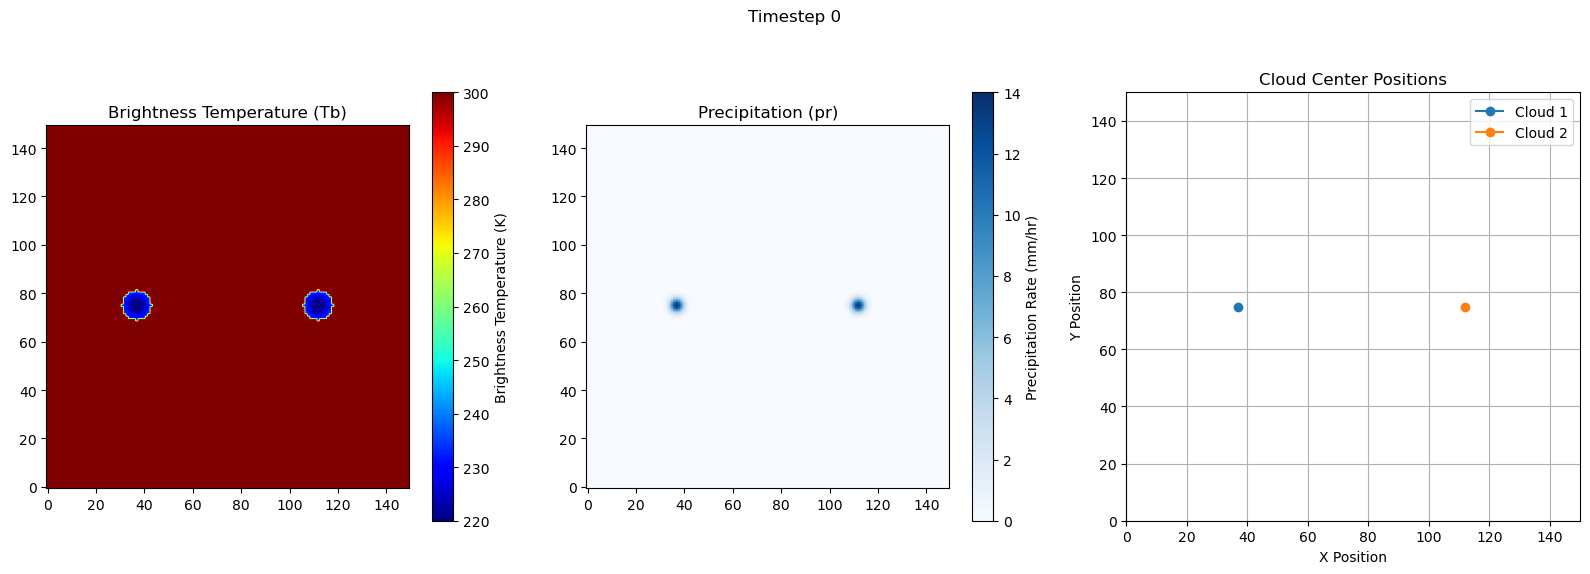

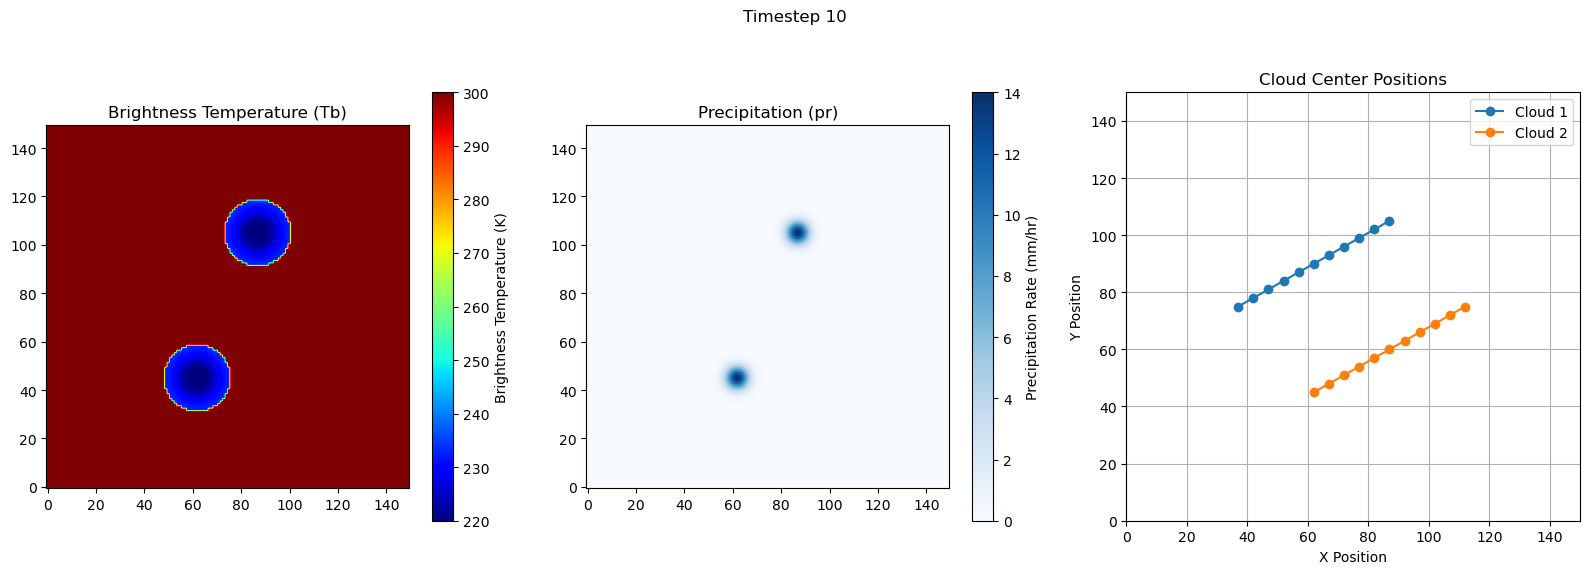

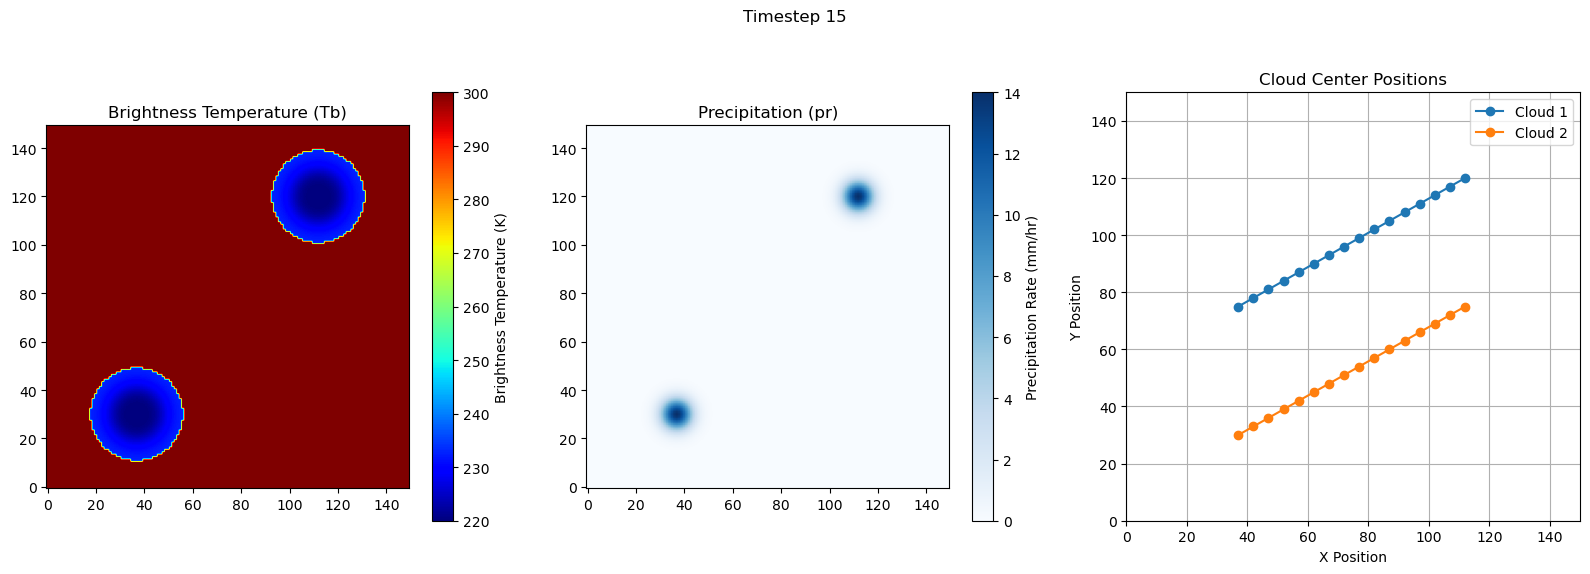

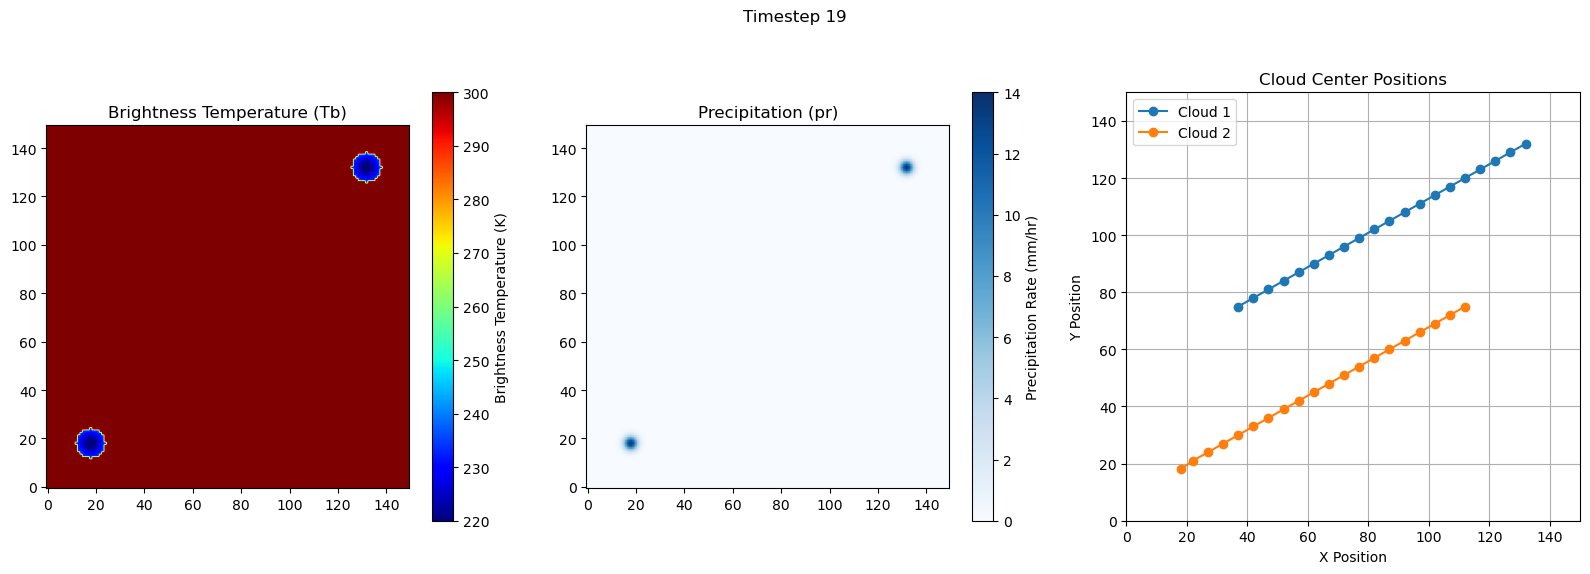

In [ ]:

timesteps_to_plot = [0, 10, 15, timesteps - 1]  # Example timesteps

for timestep in timesteps_to_plot:
    plt.figure(figsize=(16, 6))
    plt.suptitle(f'Timestep {timestep}')
    # Plot Tb
    plt.subplot(1, 3, 1)
    plt.imshow(Tb[timestep], cmap='jet', origin='lower')
    plt.colorbar(label='Brightness Temperature (K)')
    plt.title('Brightness Temperature (Tb)')

    # Plot pr
    plt.subplot(1, 3, 2)
    plt.imshow(pr[timestep], cmap='Blues', origin='lower')
    plt.colorbar(label='Precipitation Rate (mm/hr)')
    plt.title('Precipitation (pr)')

    # Plot cloud positions
    plt.subplot(1, 3, 3)
    for cloud in clouds:
        plt.plot(cloud['center_positions_x'][:timestep + 1], cloud['center_positions_y'][:timestep + 1],
                 marker='o', label=cloud['name'])
    plt.xlim(0, domain_size[0])
    plt.ylim(0, domain_size[1])
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Cloud Center Positions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 4. Prepare data and save in NetCDF format 

In [12]:
## Setting Spatial Resolution and Converting Grid Indices to Physical Coordinates

# Define grid indices for the spatial dimensions
xc = np.arange(domain_size[0])  # Grid indices along the x-axis (from 0 to domain width)
yc = np.arange(domain_size[1])  # Grid indices along the y-axis (from 0 to domain height)

dx= 10 # Spatial resolution in km per grid cell
xc_km = xc * dx  # X coordinates in km
yc_km = yc * dx  # Y coordinates in km

In [13]:
from datetime import datetime, timedelta

In [14]:
# Create a time array starting from 2020-01-01 00:00 with hourly intervals
start_time = datetime(2020, 1, 1, 0, 0, 0)
time = np.array([start_time + timedelta(hours=i) for i in range(timesteps)])

In [15]:
# Create NetCDF file
nc_filename = 'test.nc' #/pscratch/sd/p/paccini/temp/sample_data/demo/MCS4_demo_2020-01-01_00-00-00.nc'
with nc.Dataset(nc_filename, 'w', format='NETCDF4') as dataset:
    # Add global attributes
    dataset.description = "Idealized MCS to test tracking algorithms"
    dataset.author = "Laura Paccini"
    dataset.email = "laura.paccini@pnnl.gov"
    dataset.created = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    dataset.history = "Created on " + datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    dataset.title = "Idealized MCS Dataset"
    
    # Create dimensions
    dataset.createDimension('time', len(time))
    dataset.createDimension('xc', len(xc))
    dataset.createDimension('yc', len(yc))
    
    # Create variables
    times = dataset.createVariable('time', np.float64, ('time',))
    xcs = dataset.createVariable('xc', np.float32, ('xc',))
    ycs = dataset.createVariable('yc', np.float32, ('yc',))
    
    Tbs = dataset.createVariable('Tb', np.float32, ('time', 'xc', 'yc',))
    prs = dataset.createVariable('pr', np.float32, ('time', 'xc', 'yc',))
    
    # Assign data to variables
    times.units = 'hours since 2020-01-01 00:00:00'
    times.calendar = 'gregorian'
    times[:] = nc.date2num(time.tolist(), units=times.units, calendar=times.calendar)
    
    xcs.units = 'km'
    xcs.standard_name = 'X'
    xcs.long_name = 'X Coordinate'
    xcs[:] = xc_km
    
    ycs.units = 'km'
    ycs.standard_name = 'Y'
    ycs.long_name = 'Y Coordinate'
    ycs[:] = yc_km

    Tbs[:] = Tb
    prs[:] = pr

    # Define variable attributes
    Tbs.units = 'K'
    Tbs.long_name = 'Brightness Temperature'
    Tbs.standard_name = 'brightness_temperature'
    prs.units = 'mm/h'
    prs.long_name = 'Precipitation Rate'
    prs.standard_name = 'precipitation_rate'
    
print(f"NetCDF file '{nc_filename}' created successfully.")

NetCDF file 'test.nc' created successfully.


### 5. Read Files and Roll the Synthetic Clouds to Test PBC

This section reads the saved NetCDF files and applies periodic boundary conditions by rolling the cloud data along one or more axes.

In [17]:
import xarray as xr

In [18]:
test = xr.open_dataset('test.nc')

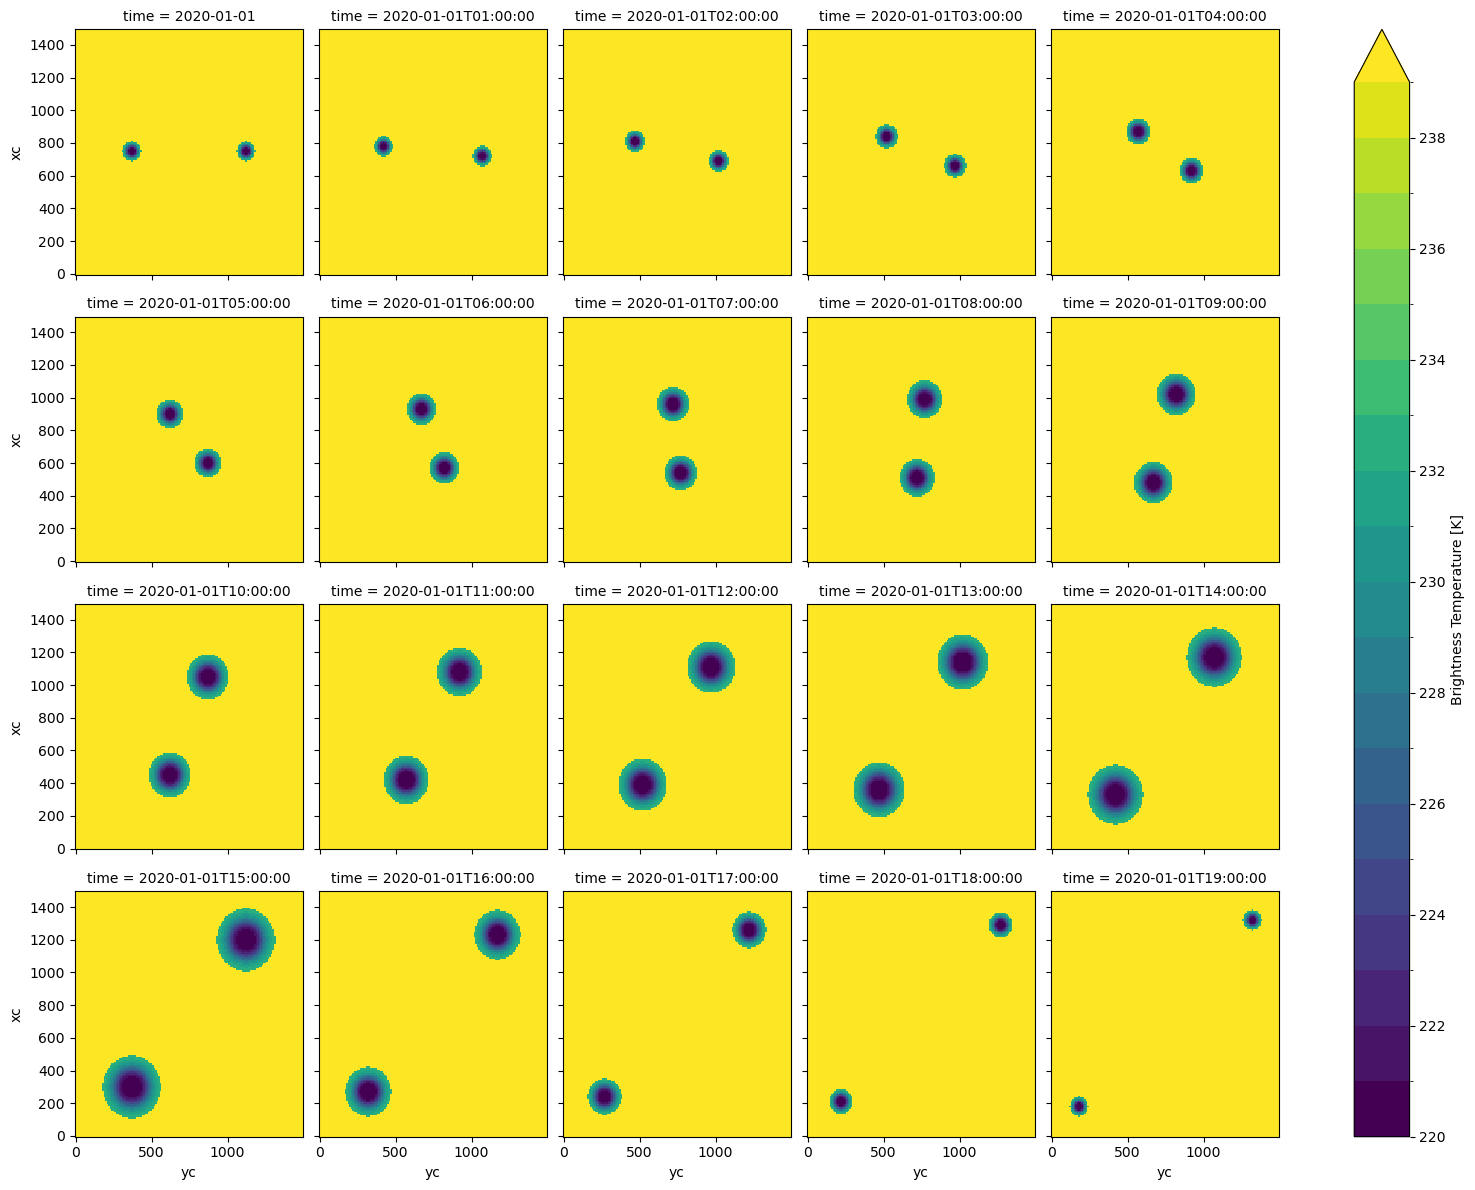

In [19]:
test.Tb.plot(col='time',col_wrap=5,levels=np.arange(220,240))

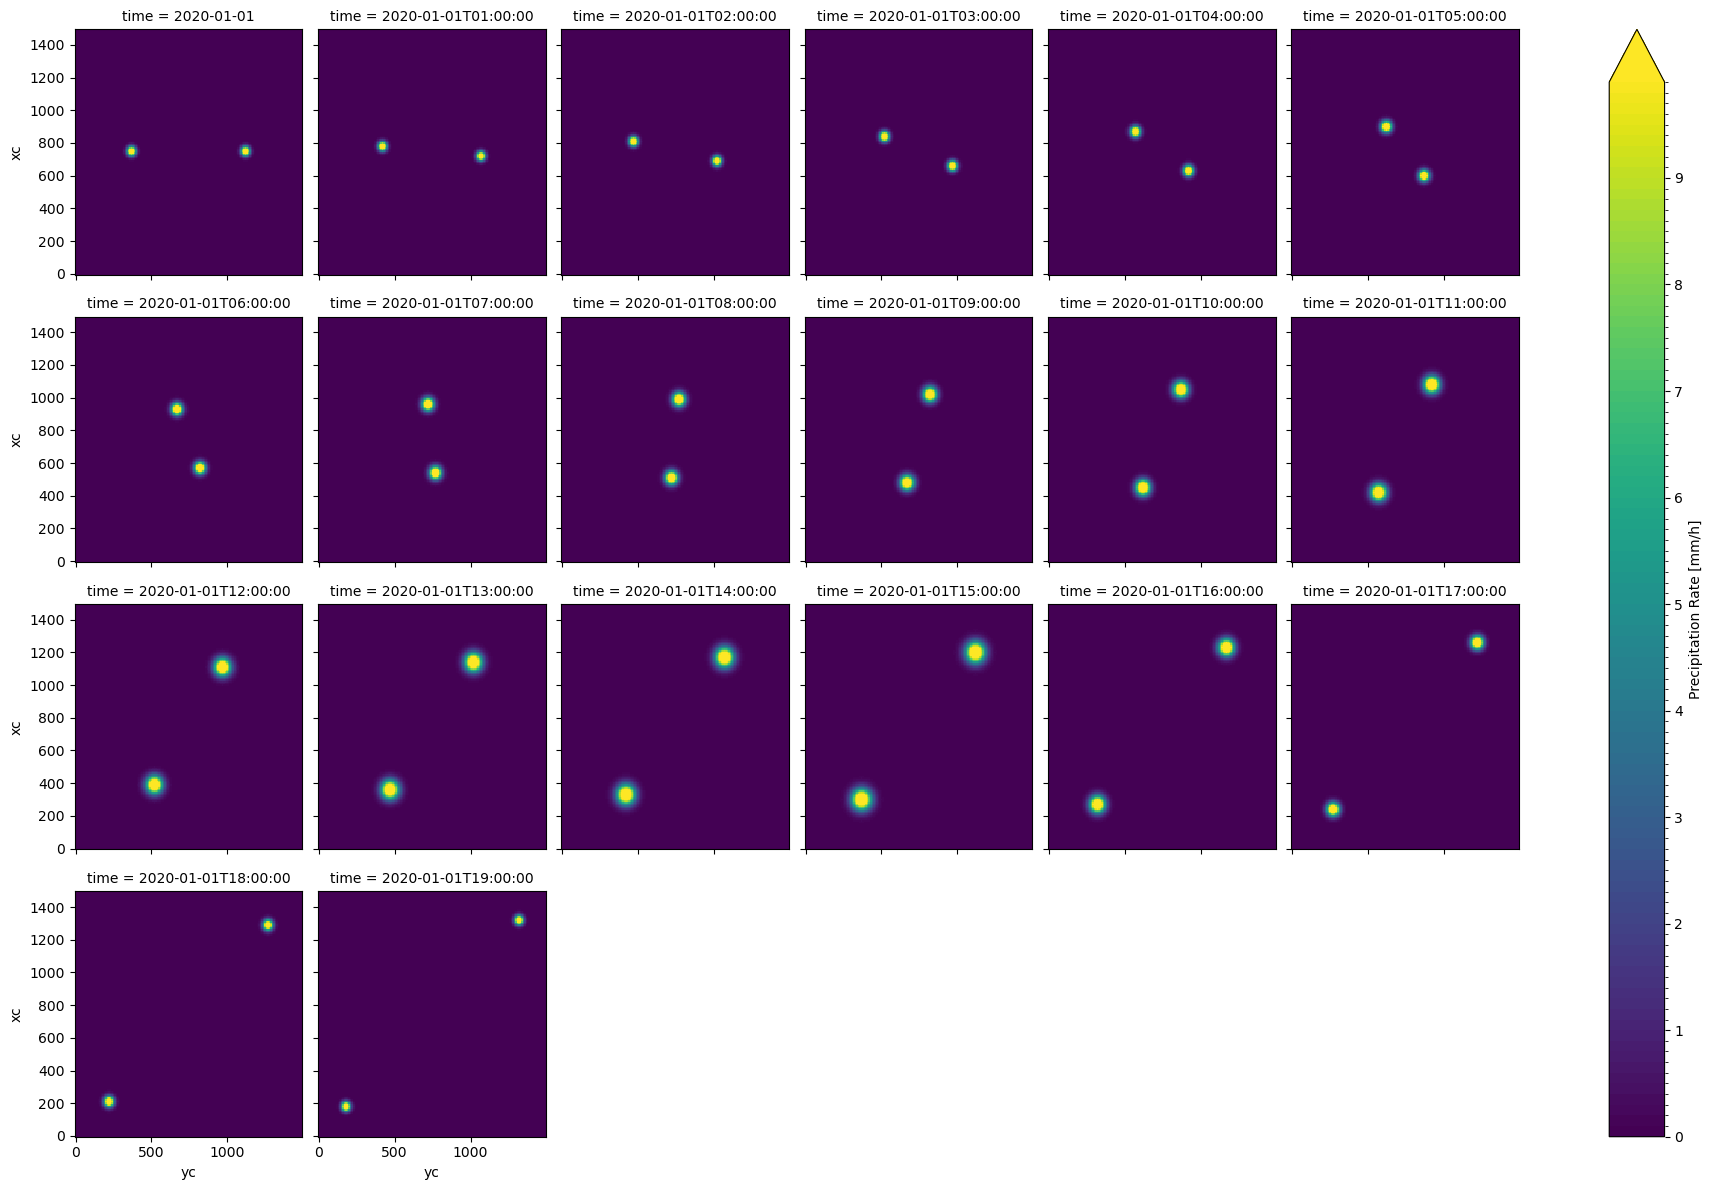

In [20]:
test.pr.plot(col='time',levels=np.arange(0,10,.1),col_wrap=6)

In [21]:
rolled_variables = test[['Tb', 'pr']].roll(xc=70,yc=70,roll_coords=False) 
# Update the variables in the original dataset
test[['Tb', 'pr']] = rolled_variables

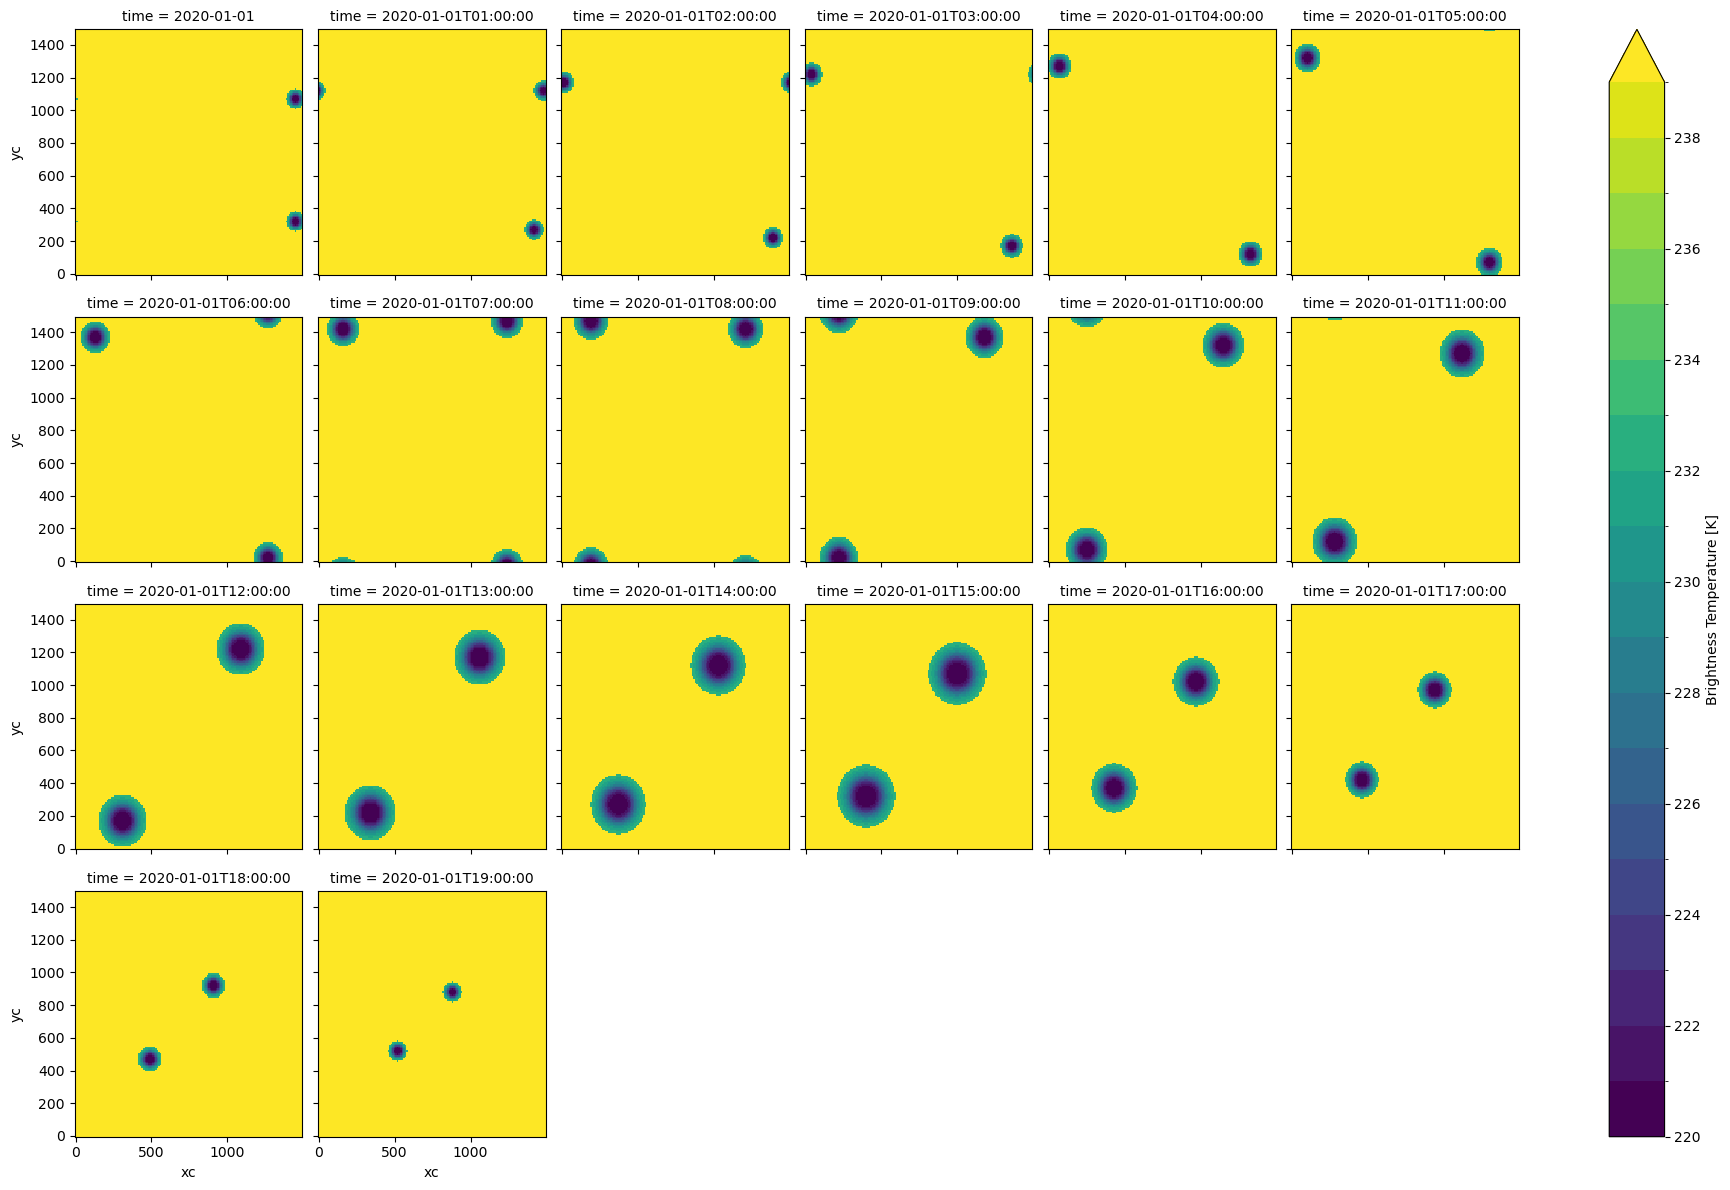

In [22]:
test.Tb.plot(col='time',levels=np.arange(220,240),x='xc',col_wrap=6)

In [23]:
test.to_netcdf('/pscratch/sd/p/paccini/temp/sample_data/demo/MCS5_demo_rolled_2020-01-01_00-00-00.nc')